* [1.Load Data From CSV File](#ld)
* [2.Build a pipeline](#bp)
* [3.Idée pour choisir le meilleur modèle](#ic)
* [4.Modèles de machine learning choisis](#mml)


In [76]:
#!pip install xgboost

In [77]:
#!pip install lightgbm 

In [78]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns

import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from  xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor


import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,StratifiedGroupKFold
from sklearn.metrics import mean_absolute_error,r2_score
from time import time


from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

### 1.Load Data From CSV File<a class="anchor" id="ld"></a>

In [79]:
#df = pd.read_csv('prepared_data.csv', sep='\t')
df = pd.read_csv('test.csv', sep='\t')
df.head()

,OSEBuildingID,BuildingType,NumberofBuildings,NumberofFloors,LargestPropertyUseType,ENERGYSTARScore,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,tranche_date,BuildingAge,groups_neighborhood,groups_PrimaryPropertyType,TotalUseTypeNumber,GFABuildingRate,GFAParkingRate
0,1,NonResidential,1.0,12,Hotel,60.0,182.500000,7226362.5,249.98,2.83,tranche_date1,89,Various,Various,1,1.00000,0.00000
1,2,NonResidential,1.0,11,Hotel,61.0,176.100006,8387933.0,295.86,2.86,tranche_date3,20,Various,Various,3,0.85455,0.14545
2,3,NonResidential,1.0,41,Hotel,43.0,241.899994,72587024.0,2089.28,2.19,tranche_date2,47,Various,Various,1,0.79425,0.20575
3,5,NonResidential,1.0,10,Hotel,56.0,216.199997,6794584.0,286.43,4.67,tranche_date1,90,Various,Various,1,1.00000,0.00000
4,8,NonResidential,1.0,18,Hotel,75.0,211.399994,14172606.0,505.01,2.88,tranche_date3,36,Various,Various,3,0.64688,0.35312


In [80]:
df.shape

(1541, 17)

In [81]:
columns=list(df.columns)
columns

['OSEBuildingID',
 'BuildingType',
 'NumberofBuildings',
 'NumberofFloors',
 'LargestPropertyUseType',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'tranche_date',
 'BuildingAge',
 'groups_neighborhood',
 'groups_PrimaryPropertyType',
 'TotalUseTypeNumber',
 'GFABuildingRate',
 'GFAParkingRate']

In [82]:
target1='TotalGHGEmissions'
target2='SiteEnergyUse(kBtu)'

In [83]:
#ici on élimine 'OSEBuildingID' et 'SiteEnergyUse(kBtu)'(target1)
cols=list(set(columns)-set(['OSEBuildingID',target1]))
cols

['SourceEUI(kBtu/sf)',
 'groups_neighborhood',
 'GFABuildingRate',
 'groups_PrimaryPropertyType',
 'ENERGYSTARScore',
 'BuildingAge',
 'GHGEmissionsIntensity',
 'SiteEnergyUse(kBtu)',
 'TotalUseTypeNumber',
 'BuildingType',
 'LargestPropertyUseType',
 'NumberofBuildings',
 'NumberofFloors',
 'GFAParkingRate',
 'tranche_date']

In [84]:
df=df[cols]

In [85]:
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
print(numercial_cols)

['SourceEUI(kBtu/sf)', 'GFABuildingRate', 'ENERGYSTARScore', 'BuildingAge', 'GHGEmissionsIntensity', 'SiteEnergyUse(kBtu)', 'TotalUseTypeNumber', 'NumberofBuildings', 'NumberofFloors', 'GFAParkingRate']


In [86]:
categorical_cols = [col for col in df.columns if df[col].dtype=="O"]
print(categorical_cols)

['groups_neighborhood', 'groups_PrimaryPropertyType', 'BuildingType', 'LargestPropertyUseType', 'tranche_date']


In [87]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

In [88]:
df['groups_neighborhood'].unique()

array(['Various', 'North', 'Central', 'South'], dtype=object)

In [89]:
df['tranche_date'].unique()

array(['tranche_date1', 'tranche_date3', 'tranche_date2', 'tranche_date4'],
      dtype=object)

In [90]:
df['groups_PrimaryPropertyType'].unique()

array(['Various', 'Commerce', 'Health'], dtype=object)

In [91]:
df.shape

(1541, 15)

In [92]:
numercial_cols_for_transformer=list(set(numercial_cols)-set([target2]))

In [93]:
numercial_cols_for_transformer

['SourceEUI(kBtu/sf)',
 'TotalUseTypeNumber',
 'GFAParkingRate',
 'GFABuildingRate',
 'NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'BuildingAge',
 'GHGEmissionsIntensity']

## 2.Build a pipeline <a class="anchor" id="bp"></a>

In [94]:
# Create pipelines for numerical and categorical features
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore",drop='first')
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [95]:
def feature_after_transformer(preprocessor):
    tx = preprocessor.get_params()['transformers']
    feature_names = []
    for name,transformer,features in tx:
        try:
            Var = preprocessor.named_transformers_[name].get_feature_names_out().tolist()
        except AttributeError:
            Var = features
        feature_names = feature_names + Var

    return feature_names

In [96]:
feature_after_transformer(preprocessor)

['SourceEUI(kBtu/sf)',
 'TotalUseTypeNumber',
 'GFAParkingRate',
 'GFABuildingRate',
 'NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'BuildingAge',
 'GHGEmissionsIntensity',
 'groups_neighborhood',
 'groups_PrimaryPropertyType',
 'BuildingType',
 'LargestPropertyUseType',
 'tranche_date']

In [97]:
y=df[[target2]]
y= StandardScaler().fit_transform(y)
features=list(set(cols)-set([target2]))
X=df[features]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 3.Idée pour choisir le meilleur modèle <a class="anchor" id="ic"></a>

In [99]:
regressors = [LinearRegression(fit_intercept=True,normalize=True,copy_X=True),
              Ridge(alpha=5,solver='auto',fit_intercept=True),
              Lasso(tol=1e-3,selection='random',fit_intercept=True),
              ElasticNet(tol=1e-3,selection='random',fit_intercept=True),
              RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'),
              SVR(kernel='rbf',degree=3,gamma='scale'),
              LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1),
              XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 100)
              ]

In [100]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

for model in regressors:
    start = time()
    #select=SelectKBest(score_func=f_regression,k=8)
    #pip = Pipeline(steps=[("preprocessor", preprocessor),("selector",select),("model", model)])
    pip = Pipeline(steps=[("preprocessor", preprocessor),("model", model)])
    
    pip.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
   
    print("\tMean squared error:", mean_squared_error(y_test, y_pred))
    print("\tRMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

LinearRegression(normalize=True)
	Training time: 0.239s
	Prediction time: 0.000s
	Mean squared error: 0.4088575676912444
	RMSE: 0.6394197116849342
	R2 score: 0.5911574907940952

Ridge(alpha=5)
	Training time: 0.062s
	Prediction time: 0.031s
	Mean squared error: 0.3973200322139661
	RMSE: 0.6303332707496615
	R2 score: 0.6026946013365733

Lasso(selection='random', tol=0.001)
	Training time: 0.031s
	Prediction time: 0.016s
	Mean squared error: 1.0241606351521602
	RMSE: 1.012008218915321
	R2 score: -0.02412291466187577

ElasticNet(selection='random', tol=0.001)
	Training time: 0.016s
	Prediction time: 0.000s
	Mean squared error: 1.0121290709004063
	RMSE: 1.0060462568393196
	R2 score: -0.01209179354031753

RandomForestRegressor(max_leaf_nodes=1000, n_estimators=300)
	Training time: 18.934s
	Prediction time: 0.220s
	Mean squared error: 0.4307639772991264
	RMSE: 0.6563261211464362
	R2 score: 0.5692518880132698

SVR()
	Training time: 0.404s
	Prediction time: 0.041s
	Mean squared error: 0.516063

**Note**
<br>
Dans la suite on va travailler sur les 3 modèles retenus ayant les 4 premiers meilleurs coefficiet de détermination r2 notamment LinearRegression,Ridge,SVR et LGBMRegressor.

## 4.Modèles de machine learning choisis<a class="anchor" id="mml"></a>

In [48]:
def f_performance(pip):
    #pip.fit(X_train,y_train)
  
    
    print('******************')
    #Check MSE and RMSE

    y_pred = pip.predict(X_test)
    print(f'MSE : {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
    print(f'R2 : {r2_score(y_test, y_pred):.3f}')

### 4.1.Regression linéaire

In [25]:
#LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, 
#and the targets predicted by the linear approximation.

In [49]:

clf_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression(fit_intercept=True,normalize=True,copy_X=True))]
)
clf_lr.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['BuildingAge',
                                                   'NumberofBuildings',
                                                   'TotalUseTypeNumber',
                                                   'GHGEmissionsIntensity',
                                                   'GFAParkingRate',
                                                   'ENERGYSTARScore',
                                                   'NumberofFloors',
                                                   'GFABuildingRate',
                                                   'GFAPerBuilding',
                                                   'PropertyGFATotal',
                                        

### 4.1.1.Indicateurs de performance

In [41]:
f_performance(clf_lr)

******************
MSE : 0.024
RMSE : 0.155
R2 : 0.980


### 4.1.2.Coéfficients du modèle

In [50]:

clf_lr.named_steps['model'].intercept_

array([-0.01487029])

In [55]:
def f_coeff(pip):
    # Putting together the coefficient and their corresponding variable names
    #pip.fit(X_train,y_train)
    df_coefficient = pd.DataFrame()
    df_coefficient["Columns"] = feature_after_transformer(preprocessor)
    df_coefficient['Estimated Coefficient '] = pd.Series(pip.named_steps['model'].coef_.flatten())
    return df_coefficient
    #print(lreg_coefficient)

In [56]:
f_coeff(clf_lr)

,Columns,Estimated Coefficient
0,BuildingAge,-3.340641e-02
1,NumberofBuildings,-6.127004e-04
2,TotalUseTypeNumber,9.885084e-03
3,GHGEmissionsIntensity,7.620150e-01
4,GFAParkingRate,9.561508e-01
5,ENERGYSTARScore,1.143359e-02
6,NumberofFloors,5.974712e-01
7,GFABuildingRate,9.821354e-01
8,GFAPerBuilding,3.730349e-13
9,PropertyGFATotal,2.682299e-13


In [57]:
font = {
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

In [59]:
def f_plot_coeff(pip_reg):
    # plotting the coefficient score
    

    fig, ax = plt.subplots(figsize =(25, 10))
 
    color =['tab:gray', 'tab:blue', 'tab:orange',
            'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
            'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
            'tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
    
    df_coefficient=f_coeff(pip_reg)
    ax.bar(df_coefficient["Columns"],
    df_coefficient['Estimated Coefficient '],
       color=color
           )

    ax.spines['bottom'].set_position('zero')
 
    plt.style.use('ggplot')
    plt.xticks(rotation=30, ha='right')
    plt.show()

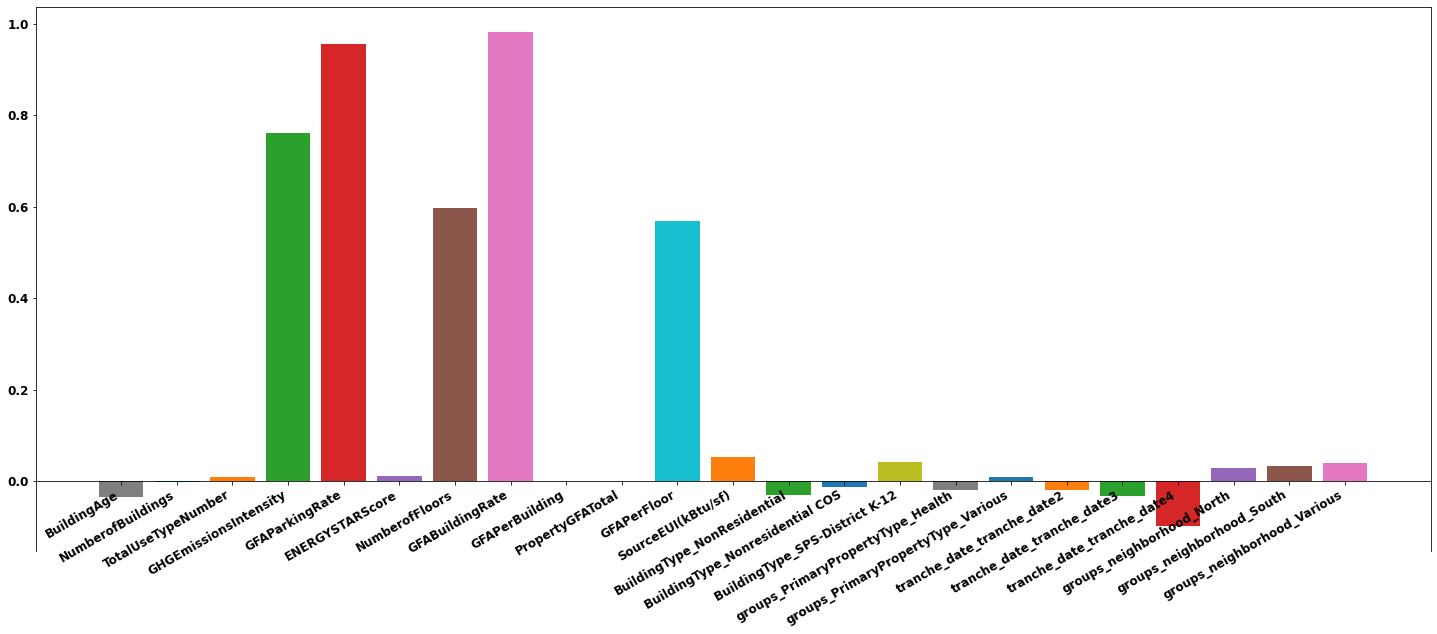

In [60]:
f_plot_coeff(clf_lr)

**Observations**
<br>
On peut remarquer que les features les plus importants sont: 'GHGEmissionsIntensity','BuildingType_Campus' et 'PropertyGFATotal'

### 4.1.3.Optimisation du modèle

#### Cross validation

In [155]:

scores = cross_val_score(clf_lr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores


array([0.56294258, 0.46986883, 0.56401485, 0.66723869, 0.73845098,
       0.73745664, 0.76901528, 0.81850531, 0.72454628, 0.69579693])

In [156]:
print(" mean of R2= %0.2f" % scores.mean())

 mean ofR2= 0.67


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

#### Ajustement des paramètres en utilisant gridsearch

In [37]:
#Paramètres à ajuster
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [38]:
#normalize:If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm
#positive:When set to True, forces the coefficients to be positive. This option is only supported for dense arrays
#copy_X: If True, X will be copied
#n_jobs:

In [39]:

#LinearRegression().get_params().keys()
param_grid = {
    
    "model__fit_intercept": [True, False],
    "model__copy_X": [True, False],
    "model__positive": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search = GridSearchCV(clf_lr, param_grid, cv=10)


In [40]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['BuildingAge',
                                                                          'GHGEmissionsIntensity',
                                                                          'NumberofBuildings',
                                                                          'SourceEUI(kBtu/sf)',
                                                                          'ENERGYSTARScore',
                                                                          'PropertyGFATotal',
                                                                   

In [41]:
df_1 = pd.DataFrame(grid_search.cv_results_).set_index('rank_test_score').sort_index()
df_1.shape

(16, 21)

In [42]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__copy_X,param_model__fit_intercept,param_model__normalize,param_model__positive,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.044549,0.081690,0.009372,0.007652,True,True,True,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.638638,...,-2.358686,-2.228505,0.035222,0.469137,0.205773,0.378961,0.467284,-0.248395,1.048130,7
1,0.018130,0.002428,0.008487,0.002415,True,True,True,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.614297,...,-3.049500,-2.567275,0.218351,0.504800,0.242287,0.394819,0.031482,-0.376721,1.241632,9
2,0.019938,0.006598,0.006286,0.006821,True,True,False,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.638638,...,-2.358686,-2.228505,0.035222,0.469137,0.205773,0.378961,0.467284,-0.248395,1.048130,5
3,0.024704,0.009068,0.010128,0.006101,True,True,False,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.614297,...,-3.049500,-2.567275,0.214066,0.504800,0.195860,0.389059,0.083142,-0.376911,1.240751,11
4,0.019325,0.007389,0.007050,0.007373,True,False,True,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.662582,...,-2.284490,-2.275786,-0.000997,0.468866,0.213103,0.380741,0.527094,-0.243716,1.047579,1
5,0.023514,0.011124,0.015393,0.014351,True,False,True,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.614297,...,-3.049500,-2.567275,0.214066,0.504800,0.195860,0.389059,0.083142,-0.376911,1.240751,11
6,0.015518,0.005737,0.008812,0.007376,True,False,False,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.662582,...,-2.284490,-2.275786,-0.000997,0.468866,0.213103,0.380741,0.527094,-0.243716,1.047579,1
7,0.022297,0.006326,0.008665,0.006043,True,False,False,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.614297,...,-3.049500,-2.567275,0.214066,0.504800,0.195860,0.389059,0.083142,-0.376911,1.240751,11
8,0.020877,0.005127,0.008822,0.004295,False,True,True,True,"{'model__copy_X': False, 'model__fit_intercept...",0.638638,...,-2.358686,-2.228505,0.035222,0.469137,0.205773,0.378961,0.467284,-0.248395,1.048130,7
9,0.021330,0.007187,0.010584,0.004984,False,True,True,False,"{'model__copy_X': False, 'model__fit_intercept...",0.614297,...,-3.049500,-2.567275,0.218351,0.504800,0.242287,0.394819,0.031482,-0.376721,1.241632,9


In [43]:
grid_search.best_params_

{'model__copy_X': True,
 'model__fit_intercept': False,
 'model__normalize': True,
 'model__positive': True}

In [44]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.479
RMSE : 0.692
R2 : 0.373


**Observations**
<br>

pas bcp de paramètre avec la regression linéaire regardons la regression polynomial

In [45]:
numeric_transformer_pol = Pipeline(
    steps=[("scaler", StandardScaler()),('poly', PolynomialFeatures(degree=5))]
)

#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor_pol = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pol, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [46]:

clf_pr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())])
clf_pr.fit(X_train,y_train)
f_performance(clf_pr)


******************
MSE : 0.471
RMSE : 0.686
R2 : 0.385


### 4.2.Ridge regression

In [157]:
clf_rr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Ridge())]
)
clf_rr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'ENERGYSTARScore',
                                                   'PropertyGFATotal',
                                                   'NumberofFloors']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

### 4.2.1.Indicateurs de performance

In [158]:
f_performance(clf_rr)

******************
MSE : 0.215
RMSE : 0.464
R2 : 0.785


 ### 4.2.2.Coéfficients du modèle

In [49]:
clf_rr.named_steps['model'].intercept_

array([0.18577373])

In [50]:
f_coeff(clf_rr)


,Columns,Estimated Coefficient
0,BuildingAge,0.013856
1,GHGEmissionsIntensity,0.551247
2,NumberofBuildings,0.100346
3,SourceEUI(kBtu/sf),-0.104736
4,ENERGYSTARScore,0.026640
5,PropertyGFATotal,0.505766
6,NumberofFloors,-0.171717
7,BuildingType,0.487703
8,tranche_date,-0.081057
9,groups_neighborhood,-0.323550


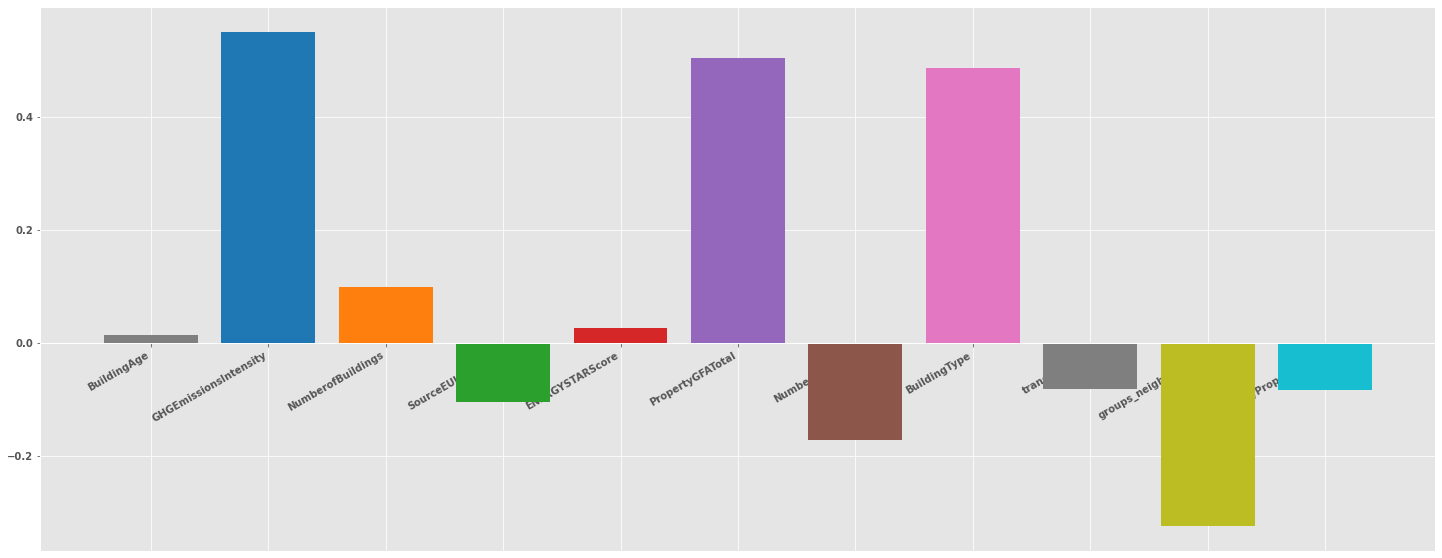

In [51]:
f_plot_coeff(clf_rr)

**Observations**
<br>
Pareil pour la regression linéaire,
on peut remarquer que les features les plus importants sont: 'GHGEmissionsIntensity','BuildingType_Campus' et 'PropertyGFATotal

### 4.2.3.Optimisation du modèle

#### Cross validation

In [159]:
scores = cross_val_score(clf_rr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

array([0.56211488, 0.46954479, 0.5649018 , 0.66873808, 0.73895658,
       0.73721745, 0.76881738, 0.81795033, 0.72452209, 0.69571827])

In [160]:

print(" mean of  R2= %0.2f" % scores.mean())

 mean of  R2= 0.67


#### Stratified K Fold

In [ ]:

StratifiedKFold

#### Ajustement des paramètres 

In [54]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

In [55]:
#{'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [ ]:
param_grid = {
    
    "model__alpha": [1,0.1,0.01,0.001,0.0001,0,5,10],
    "model__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    "model__fit_intercept": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search = GridSearchCV(clf_rr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

In [ ]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results


In [ ]:
grid_search.best_params_


In [ ]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

##### 

### 4.3.SVR

In [71]:
clf_svr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", SVR(kernel='rbf',degree=3,gamma='scale'))]
)
clf_svr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'NumberofBuildings',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

### 4.3.1.Indicateurs de performance

In [72]:
f_performance(clf_svr)

******************
MSE : 0.172
RMSE : 0.415
R2 : 0.828


### 4.3.2.Coefficients du modèle

In [ ]:

clf_svr.named_steps['model'].intercept_

In [ ]:
clf_svr.n_features_in_

In [ ]:
clf_svr.feature_names_in_

### 4.3.3.Optimisation du modèle

#### Cross validation

In [69]:
scores = cross_val_score(clf_svr, X, y, cv=10,scoring='r2')#Ajustement-des-param%C3%A8trese(clf_svr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

NameError: name 'clf_svr' is not defined

In [165]:
print(" mean of  R2= %0.2f" % scores.mean())

 mean of  R2= 0.73


#### Ajustement des paramètres

In [ ]:
SVR().get_params().keys()

In [32]:
param_grid = {
    
    "model__C": [1,0.1,0.01,0.001,0.0001,0.00001,0.00001,2,3,4,5,10],
    "model__epsilon": [0.0001, 0.001, 0.1, 1, 0.005, 0.0009],
    #"model__kernel": [True, False],
    #"model__gamma": [True, False],
    
}

grid_search = GridSearchCV(clf_svr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          'ENERGYSTARScore',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'NumberofFloors',
                                                                          'SourceEUI(kBtu/sf)',
                                                                

In [167]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.211700,0.015822,0.038862,0.007657,1,0.0001,"{'model__C': 1, 'model__epsilon': 0.0001}",0.760351,0.832593,0.819486,0.690659,0.769324,0.813677,0.797454,0.767352,0.810879,0.787443,0.784922,0.038952,9
1,0.192828,0.007017,0.037497,0.007654,1,0.001,"{'model__C': 1, 'model__epsilon': 0.001}",0.760340,0.832689,0.819503,0.690600,0.769162,0.813691,0.797480,0.767556,0.810808,0.787364,0.784919,0.038974,10
2,0.164715,0.007393,0.032681,0.004746,1,0.1,"{'model__C': 1, 'model__epsilon': 0.1}",0.764352,0.836011,0.819507,0.702039,0.778817,0.819998,0.797071,0.770160,0.811143,0.797168,0.789627,0.036535,2
3,0.029703,0.004694,0.012497,0.006248,1,1,"{'model__C': 1, 'model__epsilon': 1}",0.596125,0.597336,0.673545,0.575036,0.643573,0.691014,0.619296,0.678913,0.681418,0.673813,0.643007,0.040518,31
4,0.195326,0.007811,0.037498,0.007653,1,0.005,"{'model__C': 1, 'model__epsilon': 0.005}",0.760189,0.833024,0.819344,0.690705,0.768911,0.813985,0.797507,0.768282,0.810709,0.787564,0.785022,0.038981,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2.309679,0.192824,0.040621,0.010362,100,0.001,"{'model__C': 100, 'model__epsilon': 0.001}",0.633086,0.736577,0.708075,0.631695,0.665878,0.720099,0.731262,0.671099,0.758899,0.636853,0.689352,0.045000,28
62,1.412421,0.097639,0.034439,0.009585,100,0.1,"{'model__C': 100, 'model__epsilon': 0.1}",0.655452,0.755039,0.735559,0.662720,0.677974,0.745661,0.743879,0.691378,0.757909,0.667656,0.709323,0.039709,26
63,0.051557,0.007161,0.009377,0.007656,100,1,"{'model__C': 100, 'model__epsilon': 1}",0.606206,0.605430,0.666987,0.570193,0.649476,0.642689,0.606701,0.658388,0.690132,0.701864,0.639807,0.039777,33
64,1.984457,0.155840,0.042182,0.010004,100,0.005,"{'model__C': 100, 'model__epsilon': 0.005}",0.634420,0.737339,0.707688,0.635284,0.667291,0.721423,0.732795,0.672455,0.758797,0.638653,0.690614,0.044323,27


In [34]:
grid_search.best_params_

{'model__C': 4, 'model__epsilon': 0.1}

In [35]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.182
RMSE : 0.426
R2 : 0.818


In [173]:
print(best_estim.params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'NumberofBuildings',
                                                   'SourceEUI(kBtu/sf)',
                                                   'ENERGYSTARScore',
                                                   'PropertyGFATotal',
                                                   'NumberofFloors']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

In [177]:
#for parameter in model.get_params():
#    print(parameter)
#print(model.get_params()['gamma'])

### 4.4.LGBMRegressor

In [26]:
clf_lgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1))]
)
clf_lgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'NumberofBuildings',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

### 4.4.1.Indicateurs de performance

In [50]:
f_performance(clf_lgb)

******************
MSE : 0.189
RMSE : 0.435
R2 : 0.811


### 4.4.2.Optimisation du modèle

In [52]:
#### Cross validation

#### Ajustement des paramètres

In [33]:
list(clf_lgb.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__boosting_type',
 'model__class_weight',
 'model__colsample_bytree',
 'model__importance_type',
 'model__learning_rate',
 'model__max_depth',
 'model__min_child_samples',
 'model__min_child_weight',
 'model__min_split_gain',
 'model__n_estimators',
 'model__n_jobs'

In [27]:
param_grid = {
    
    "model__max_depth": [5,10,20,15,30],
    "model__num_leaves": [150,50,10,20,5,100],
     "model__boosting_type": ['gbdt', 'rbf','dart','goss'],
    "model__learning_rate": [0.1, 0.01,1,0.5,0.6,0.7,0.4],
    
}

grid_search = GridSearchCV(clf_lgb, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'NumberofFloors',
                                                                          'BuildingAge',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'NumberofBuildings',
                                                                    

In [29]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__learning_rate,param_model__max_depth,param_model__num_leaves,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.252724,0.009294,0.010939,0.007162,gbdt,0.1,5,150,"{'model__boosting_type': 'gbdt', 'model__learn...",0.786912,...,0.698551,0.816578,0.844575,0.782131,0.791736,0.814520,0.813107,0.802140,0.040171,17
1,0.248728,0.011460,0.012503,0.006252,gbdt,0.1,5,50,"{'model__boosting_type': 'gbdt', 'model__learn...",0.786912,...,0.698551,0.816578,0.844575,0.782131,0.791736,0.814520,0.813107,0.802140,0.040171,17
2,0.200010,0.009383,0.007813,0.007813,gbdt,0.1,5,10,"{'model__boosting_type': 'gbdt', 'model__learn...",0.791256,...,0.731509,0.816881,0.845364,0.784756,0.797458,0.809827,0.809742,0.804741,0.030289,15
3,0.244512,0.008224,0.012502,0.006251,gbdt,0.1,5,20,"{'model__boosting_type': 'gbdt', 'model__learn...",0.794191,...,0.702738,0.816343,0.848792,0.784811,0.789372,0.815860,0.806462,0.802928,0.038986,16
4,0.126842,0.004661,0.007813,0.007813,gbdt,0.1,5,5,"{'model__boosting_type': 'gbdt', 'model__learn...",0.803717,...,0.738135,0.816155,0.856883,0.774122,0.795179,0.812565,0.813406,0.806093,0.030495,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.284876,0.011755,0.008949,0.006470,goss,0.4,30,50,"{'model__boosting_type': 'goss', 'model__learn...",0.667933,...,0.610479,0.709795,0.770026,0.715453,0.668673,0.721847,0.710302,0.705035,0.043523,198
836,0.222245,0.010743,0.011247,0.004638,goss,0.4,30,10,"{'model__boosting_type': 'goss', 'model__learn...",0.686696,...,0.570533,0.745405,0.757007,0.679757,0.696956,0.762750,0.687696,0.702032,0.052506,210
837,0.284517,0.010259,0.007664,0.004492,goss,0.4,30,20,"{'model__boosting_type': 'goss', 'model__learn...",0.682237,...,0.605041,0.727203,0.757388,0.703878,0.685496,0.745249,0.644648,0.704285,0.049187,207
838,0.139982,0.012469,0.008056,0.006997,goss,0.4,30,5,"{'model__boosting_type': 'goss', 'model__learn...",0.725810,...,0.687201,0.771668,0.809937,0.708573,0.742673,0.782646,0.743190,0.755604,0.038417,144


In [31]:
grid_search.best_params_

{'model__boosting_type': 'dart',
 'model__learning_rate': 0.4,
 'model__max_depth': 5,
 'model__num_leaves': 5}

In [32]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.164
RMSE : 0.405
R2 : 0.836


## 4.5.RandomForestRegressor

In [34]:
clf_rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'))]
)
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'NumberofBuildings',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

### 4.5.1.Indicateurs de performance

In [35]:
f_performance(clf_rf)

******************
MSE : 0.181
RMSE : 0.425
R2 : 0.819


### 4.5.2.Optimisation du modèle

In [36]:
list(clf_rf.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__bootstrap',
 'model__ccp_alpha',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__max_samples',
 'model__min_impurity_decrease',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fracti

In [39]:
param_grid = {
    
    "model__max_leaf_nodes": [1000,5000,100000,None],
    "model__n_estimators": [150,50,10,250,100],
     "model__criterion": ['squared_error', 'absolute_error', 'poisson']
    
}
grid_search = GridSearchCV(clf_rf, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'NumberofFloors',
                                                                          'BuildingAge',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'NumberofBuildings',
                                                                    

In [40]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_leaf_nodes,param_model__n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.235810,0.051455,0.034659,6.190005e-03,squared_error,1000,150,"{'model__criterion': 'squared_error', 'model__...",0.770524,0.827315,...,0.693124,0.794743,0.854187,0.774557,0.774623,0.801739,0.786490,0.787243,0.039843,14
1,0.428158,0.017367,0.017189,4.686515e-03,squared_error,1000,50,"{'model__criterion': 'squared_error', 'model__...",0.771979,0.826657,...,0.689270,0.791459,0.848125,0.765537,0.767325,0.802081,0.782436,0.782573,0.040054,32
2,0.095305,0.004687,0.010952,7.169625e-03,squared_error,1000,10,"{'model__criterion': 'squared_error', 'model__...",0.746031,0.811385,...,0.674965,0.786020,0.818058,0.754737,0.754133,0.792312,0.751151,0.764870,0.038809,39
3,2.028242,0.027768,0.050011,6.243204e-03,squared_error,1000,250,"{'model__criterion': 'squared_error', 'model__...",0.775747,0.830181,...,0.704650,0.792418,0.850576,0.775838,0.773812,0.807358,0.784881,0.788157,0.036809,7
4,0.828063,0.051981,0.025001,7.654130e-03,squared_error,1000,100,"{'model__criterion': 'squared_error', 'model__...",0.774419,0.834681,...,0.710001,0.793383,0.850772,0.765663,0.762001,0.805934,0.778287,0.786807,0.037440,18
5,1.235894,0.022253,0.032812,4.686952e-03,squared_error,5000,150,"{'model__criterion': 'squared_error', 'model__...",0.773079,0.825579,...,0.701369,0.791862,0.850841,0.770967,0.775633,0.807113,0.784880,0.787313,0.037325,13
6,0.431284,0.028135,0.018751,6.249499e-03,squared_error,5000,50,"{'model__criterion': 'squared_error', 'model__...",0.771545,0.827661,...,0.710311,0.785841,0.848384,0.760372,0.763141,0.798309,0.789374,0.784443,0.035910,29
7,0.096879,0.006244,0.009375,7.654967e-03,squared_error,5000,10,"{'model__criterion': 'squared_error', 'model__...",0.742813,0.814829,...,0.709604,0.777278,0.831094,0.762883,0.761612,0.789349,0.750571,0.769871,0.033441,34
8,2.048421,0.062744,0.049998,6.249285e-03,squared_error,5000,250,"{'model__criterion': 'squared_error', 'model__...",0.774959,0.826081,...,0.699128,0.789415,0.851055,0.770582,0.771927,0.806884,0.784643,0.785883,0.037942,24
9,0.828179,0.027067,0.025000,7.654003e-03,squared_error,5000,100,"{'model__criterion': 'squared_error', 'model__...",0.776885,0.822717,...,0.700846,0.792048,0.851775,0.775123,0.776099,0.807875,0.782563,0.786461,0.037153,20


In [41]:
grid_search.best_params_

{'model__criterion': 'absolute_error',
 'model__max_leaf_nodes': 100000,
 'model__n_estimators': 150}

In [42]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.178
RMSE : 0.422
R2 : 0.822


## 4.6.XGBRegressor

In [50]:
clf_xg = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123))]
)
clf_xg.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'NumberofBuildings',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

### 4.6.1.Indicateurs de performance

In [51]:
f_performance(clf_xg)

******************
MSE : 0.181
RMSE : 0.426
R2 : 0.819


### 4.6.2.Optimisation du modèle

In [65]:
list(clf_xg.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__objective',
 'model__base_score',
 'model__booster',
 'model__callbacks',
 'model__colsample_bylevel',
 'model__colsample_bynode',
 'model__colsample_bytree',
 'model__early_stopping_rounds',
 'model__enable_categorical',
 'model__eval_metric',
 'model__gamma',
 '

In [62]:
param = {"booster":"gblinear", "objective":"reg:linear"}
clf_test = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 100))]
)
clf_test.fit(X_train,y_train)
f_performance(clf_test)

******************
MSE : 0.177
RMSE : 0.421
R2 : 0.823


In [66]:
param_grid = {
    
    "model__booster": ['squarederror','gbtree'],
    "model__n_estimators": [150,50,10,20,500,100,5],
    
    "model__max_leaves": [10000, 100000,1000,100],
    "model__learning_rate": [0.3, 0.5,0.1,0.01,0.001]
    
}

grid_search = GridSearchCV(clf_xg, param_grid, cv=10)
grid_search.fit(X_train,y_train)

[16:27:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:29:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:32:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:33:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:33:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:33:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:34:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:35:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:35:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:35:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:36:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:36:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:37:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:37:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'NumberofFloors',
                                                                          'BuildingAge',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'NumberofBuildings',
                                                                    

In [67]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
grid_search.best_params_
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.176
RMSE : 0.420
R2 : 0.824
